# RidgeRegression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The Model

In [2]:
def ridge_regression(X, y, max_iter=10000, learning_rate=0.01, tolerance=0.1, max_grad=1e6, lambda_regul=0.0,
                              learning_rate_decay=True):
    '''Runs Gradient Descent on the data.
    Returns Parameters learned by the model and costs, scores and gradient magnitudes lists 
    computed so far during training respectively in order.
    '''
    
    m = X.shape[0]                                      # Training Examples
    n = X.shape[1]                                      # No. of features
    X = np.hstack((np.ones((m,1)), X))                  # Adding a column of ones for 0th feature i.e. Intercept
    w = np.zeros((n+1, n))#random.randn(n+1, 1) * np.sqrt(2.0 / n)      # Random (He) initialization of weights
    costs = []
    scores = []
    gradient_magnitudes = []
    
    for t in range(max_iter):
        
        y_cap = np.matmul(X, w)
        error = y - y_cap
        dw = -2 * np.matmul(X.T, error)
        dw = np.clip(dw, -max_grad, max_grad)           # Avoiding Vanishing/Exploding Gradients
        w = w * (1 - 2 * learning_rate * lambda_regul) # Weights Penalization except intercept
        w -= learning_rate * dw
        
        cost = np.matmul(error.T, error)
        score = 1 - (cost / ((y - y.mean()) ** 2).sum()) # coefficient R^2
        costs.append(cost.flatten()[0])
        scores.append(score.flatten()[0])
        
        gradient_magnitude = np.linalg.norm(dw)
        gradient_magnitudes.append(gradient_magnitude)
        if gradient_magnitude < tolerance:
            break
            
        if learning_rate_decay and (t+1) % 100 == 0:
            learning_rate = learning_rate / np.sqrt(t)    # Learning rate decay over every 100th iteration
        
    return w, costs, scores, gradient_magnitudes

def score(X, y, w):
    '''Returns the coefficient R^2 score of the model
    '''
    if X.shape[1] < w.shape[0]:
        X = np.hstack((np.ones((X.shape[0],1)), X))
    y_cap = np.matmul(X, w)
    error = y - y_cap
    cost = np.matmul(error.T, error)
    score = 1 - (cost / ((y - y.mean()) ** 2).sum())
    
    return score.flatten()[0]

def predict(X, w):
    
    if X.shape[1] < w.shape[0]:
        X = np.hstack((np.ones((X.shape[0],1)), X))
    
    return np.matmul(X, w)

def generate_polynomial_features(x, degree=2):
    X = np.empty((x.shape[0], degree), dtype=x.dtype)
    
    for i in range(degree):
        X[:,i] = x[:,0] ** (i+1)
    
    return X
    

### Linear Data with noise and outliers

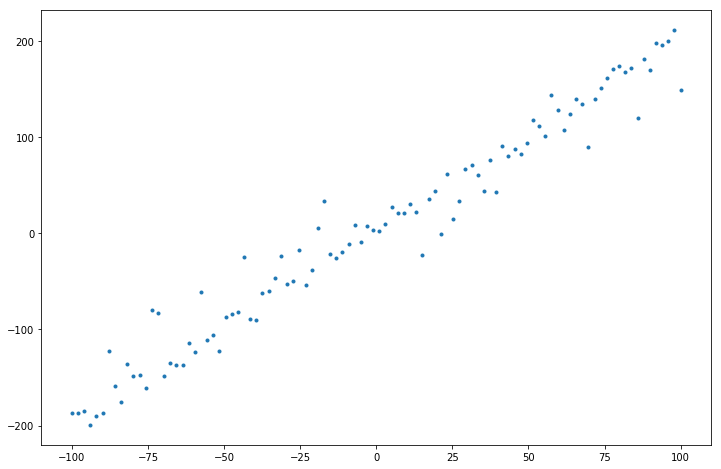

In [64]:
x = np.linspace(-100,100,100).reshape((-1,1))
y =  2 * x + 5
y = y + np.random.randn(x.shape[0],1) * 10                  # Adding noise to data
outlier_indices = np.random.randint(0, 50, 10)
y[outlier_indices] = y[outlier_indices] + 50               # Adding outliers
outlier_indices = np.random.randint(50, 100, 10)
y[outlier_indices] = y[outlier_indices] - 50               # Adding outliers
plt.figure(figsize=(12,8))
plt.plot(x[:,0], y, '.')

### Generating Polynomial Features

In [65]:
X = generate_polynomial_features(x, degree=3)
X.shape

(100, 3)

### Fitting non-regularized model on Polynomial Features

0.920049501372424

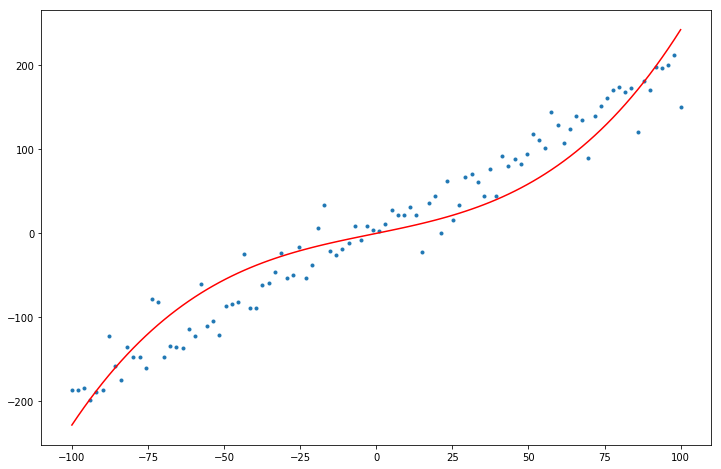

In [104]:
w, costs, _, _ = ridge_regression(X, y, max_grad=100, tolerance=200)
plt.figure(figsize=(12,8))
plt.plot(X[:,0], y, '.' , X[:,0], predict(X,w), 'r')
score(X,y,w)

We can clearly see the effects of outliers. The model is inclined towards the outliers.

### Fitting a regularized model on Polynomial Features

0.9592320386733447

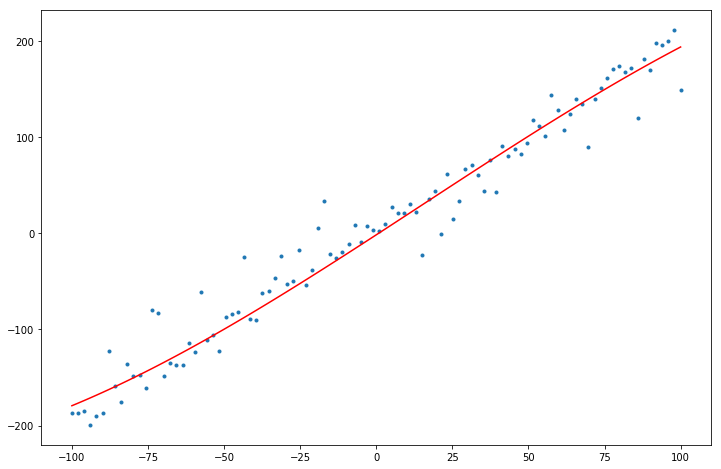

In [110]:
w, costs, _, _ = ridge_regression(X, y, max_grad=100, lambda_regul=0.1)
plt.figure(figsize=(12,8))
plt.plot(X[:,0], y, '.' , X[:,0], predict(X,w), 'r')
score(X,y,w)

The regularized model is more smoothly fitting the general trend of the data.

### How to choose lambda_regul?

#### k-fold cross validation

In [69]:
def k_fold_cross_validation(X, y, lambda_regul_list, k=10):
    
    m = X.shape[0]                            # No. of examples
    n = X.shape[1]                            # No. of features
    
    train_scores = []
    validation_scores = []
    
    for lambda_regul in lambda_regul_list:
        
        train_score = 0
        validation_score = 0
        
        for i in range(k):
            
            start = (m * i) // k
            end = (m * (i + 1)) // k-1
            
            X_valid = X[start:end+1, :]
            y_valid = y[start:end+1, :]
            
            X_train = np.append(X[:start, :], X[end+1:, :], axis=0)
            y_train = np.append(y[:start, :], y[end+1:, :], axis=0)
            
            w, _, _, _ = ridge_regression(X_train, y_train, max_grad=1e7, lambda_regul=lambda_regul)
            
            train_score += score(X_train, y_train, w)
            validation_score += score(X_valid, y_valid, w)
            
        train_score /= k
        train_scores.append(train_score)
        validation_score /= k
        validation_scores.append(validation_score)
    
    return train_scores, validation_scores        

### Ridge Regression on Housing data with all features

In [90]:
df = pd.read_csv('data/LinearRegression_kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,20141013T000000,221900,3,1.00,1180.0,5650,1.0,0,0,3,7,1180,0,1955.0,NaN,98178.0,47.5112,-122.257
1,6414100192,20141209T000000,538000,3,2.25,2570.0,7242,2.0,0,0,3,7,2170,400,1951.0,1991.0,98125.0,47.7210,-122.319
2,5631500400,20150225T000000,180000,2,1.00,770.0,10000,1.0,0,0,3,6,770,0,1933.0,NaN,98028.0,47.7379,-122.233
3,2487200875,20141209T000000,604000,4,3.00,1960.0,5000,1.0,0,0,5,7,1050,910,1965.0,NaN,98136.0,47.5208,-122.393
4,1954400510,20150218T000000,510000,3,2.00,1680.0,8080,1.0,0,0,3,8,1680,0,1987.0,NaN,98074.0,47.6168,-122.045


#### Analyzing nan values of the data

In [91]:
df.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          8
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             6
yr_renovated     20699
zipcode              4
lat                  0
long                 0
dtype: int64

#### Filling nan values of the data with most approprite methods

In [92]:
df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])
df['zipcode'] = df['zipcode'].fillna(method='ffill')
df['sqft_living'] = df['sqft_living'].fillna(df['sqft_living'].mean())
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         6
yr_renovated     6
zipcode          0
lat              0
long             0
dtype: int64

Only 6 rows will be dropped with nan values

#### Dropping unuseful columns such as date, id, ...

In [93]:
columns_to_select = []
for column in df.columns:
    if column not in ['id', 'date', 'price']:
        columns_to_select.append(column)
columns_to_select

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long']

In [94]:
df = df[columns_to_select + ['price']].dropna()     # Only 6 rows dropped
X = np.array(df[columns_to_select])
y = np.array(df['price']).reshape(-1,1)
print(X.shape, y.shape)

(21607, 16) (21607, 1)


#### Train Test Split and normalization

In [95]:
train_size = int(0.8*X.shape[0])
random_indices = np.random.permutation(X.shape[0])
X_train = X[random_indices[:train_size], :]
X_test = X[random_indices[train_size:], :]
y_train = y[random_indices[:train_size], :]
y_test = y[random_indices[train_size:], :]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
X_train = (X_train - means) / stds

(17285, 16) (4322, 16) (17285, 1) (4322, 1)


#### Running k-fold cross validation on the data for different values of lambda_regul

In [98]:
lambda_regul_list = np.logspace(-7, 3, num=10)
train_scores, validation_scores = k_fold_cross_validation(X_train, y_train, lambda_regul_list)

#### Training the model with the best value of lambda_regul determined by k-fold cross validation

In [99]:
w = ridge_regression(X_train, y_train, max_grad=1e7, lambda_regul=lambda_regul_list[np.argmax(validation_scores)])[0]
score(X_train, y_train, w)

0.6986061281473497

In [100]:
score((X_test - means) / stds, y_test, w)

0.6982311036244548

We can see a significant increase in test set performance compared to our previous model in the Multiple Regression notebook.